In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
import msgpack

from stellarpunk import econ_sim, serialization

In [2]:
%load_ext autoreload
%autoreload 1
%aimport stellarpunk.serialization
%aimport stellarpunk.econ_sim

In [3]:
#production_chain_df = pd.DataFrame(msgpack.unpackb(open("/tmp/production_chain.log", "rb").read(), object_hook=serialization.decode_matrix))
production_chain = serialization.load_production_chain(open("/tmp/production_chain.log", "rb").read())
production_chain_df = production_chain.adj_matrix

In [4]:
production_chain_df.shape

(7, 7)

In [5]:
agent_goods_df = pd.DataFrame(msgpack.unpackb(open("/tmp/agent_goods.log", "rb").read(), object_hook=serialization.decode_matrix))

In [6]:
agent_goods_df

,0,1,2,3,4,5,6
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Transactions

In [7]:
columns = ["tick", "seller", "buyer", "product", "amount", "price"]
transaction_df = pd.read_csv("/tmp/transactions.log", sep="\t", header=None, names=columns)

In [8]:
transaction_df["value"] = transaction_df["amount"] * transaction_df["price"]

In [9]:
transaction_df

,tick,seller,buyer,product,amount,price,value
0,0,0,2,0,10.0,15.154425,151.544248
1,0,1,3,1,10.0,6.907915,69.079147
2,1,1,3,1,96.0,11.280813,1082.958014
3,1,0,2,0,96.0,15.292603,1468.089909
4,2,1,3,1,689.0,11.280813,7772.479915
...,...,...,...,...,...,...,...
139837,99850,1,3,1,10000.0,9.722334,97223.339613
139838,99851,1,3,1,10000.0,9.722334,97223.339613
139839,99852,1,3,1,10000.0,9.722334,97223.339613
139840,99853,1,3,1,10000.0,9.722334,97223.339613


Text(0.5, 1.0, 'transaction count by tick')

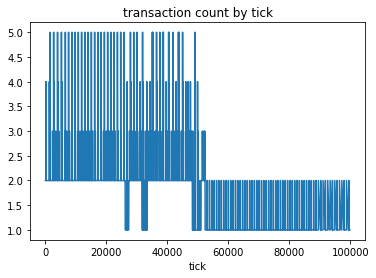

In [10]:
transaction_df.groupby("tick")["price"].count().plot()
plt.title("transaction count by tick")

Text(0.5, 1.0, 'product 0 transaction count per tick')

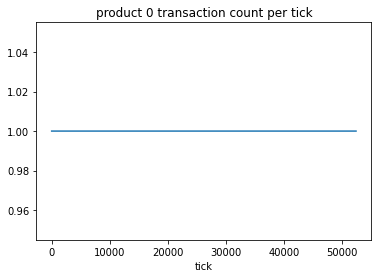

In [11]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].count().plot()
plt.title("product 0 transaction count per tick")

Text(0.5, 1.0, 'transaction unit quantity per tick')

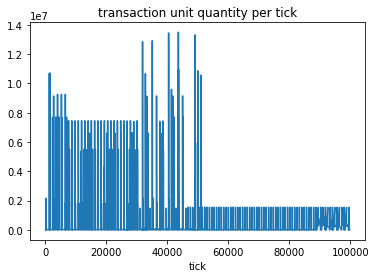

In [12]:
transaction_df.groupby("tick")["amount"].sum().plot()
plt.title("transaction unit quantity per tick")

Text(0.5, 1.0, 'transaction value per tick')

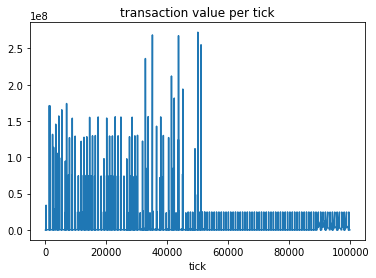

In [13]:
transaction_df.groupby("tick")["value"].sum().plot()
plt.title("transaction value per tick")

Text(0.5, 1.0, 'distinct products sold per tick')

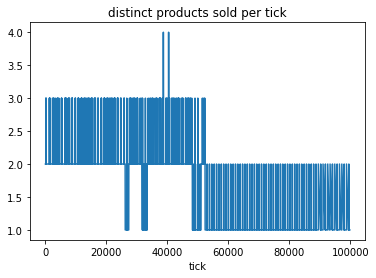

In [14]:
transaction_df.groupby("tick")["product"].nunique().plot()
plt.title("distinct products sold per tick") 

Text(0.5, 1.0, 'distinct sellers per tick')

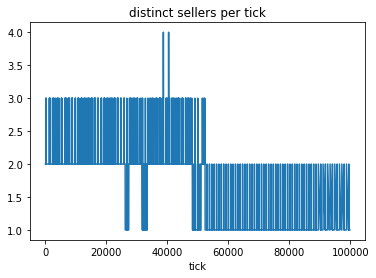

In [15]:
transaction_df.groupby("tick")["seller"].nunique().plot()
plt.title("distinct sellers per tick")

Text(0.5, 1.0, 'distinct buyers per tick')

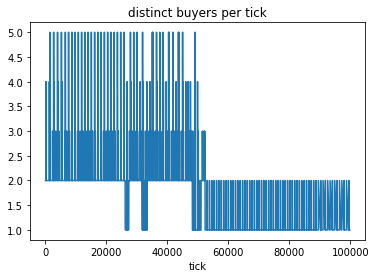

In [16]:
transaction_df.groupby("tick")["buyer"].nunique().plot()
plt.title("distinct buyers per tick")

In [17]:
transaction_df["seller"].nunique()

4

In [18]:
transaction_df["buyer"].nunique()

5

In [19]:
transaction_df["product"].nunique()

4

<AxesSubplot:>

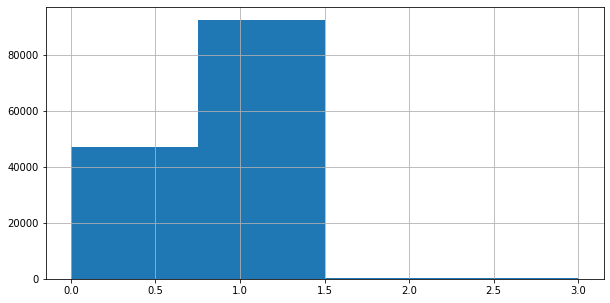

In [20]:
plt.figure(figsize=(10,5))
transaction_df["product"].hist(bins=transaction_df["product"].max()+1)

Text(0.5, 1.0, 'max product id sold each tick')

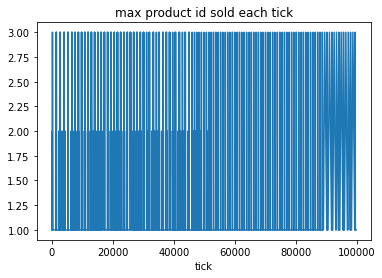

In [21]:
transaction_df.groupby("tick")["product"].max().plot()
plt.title("max product id sold each tick")

In [22]:
transaction_df[transaction_df["seller"] == 3]["price"].describe()

count    411.000000
mean      12.939044
std        2.372355
min        7.861908
25%       11.070473
50%       13.056007
75%       15.960157
max       16.029866
Name: price, dtype: float64

Text(0.5, 1.0, 'price of product 0 over time')

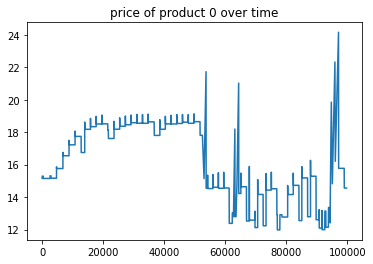

In [76]:
transaction_df[transaction_df["seller"] == 0]["price"].plot()
plt.title("price of product 0 over time")

Text(0.5, 1.0, 'price of product 2 over time')

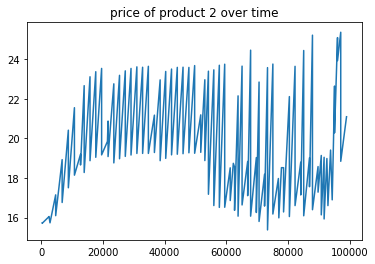

In [83]:
transaction_df[transaction_df["seller"] == 2]["price"].plot()
plt.title("price of product 2 over time")

Text(0.5, 1.0, 'price of product 6 over time')

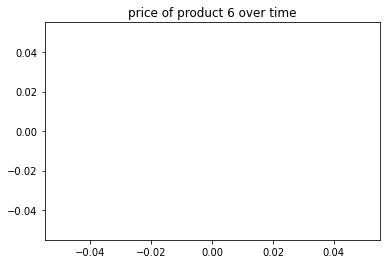

In [24]:
transaction_df[transaction_df["seller"] == 6]["price"].plot()
plt.title("price of product 6 over time")

<AxesSubplot:>

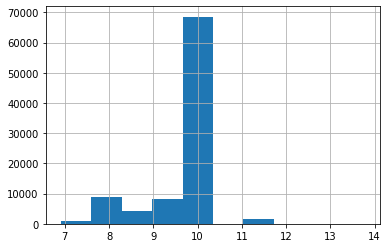

In [25]:
transaction_df[transaction_df["buyer"] == 3]["price"].hist()

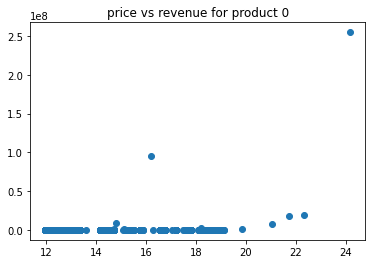

In [26]:
plt.scatter(transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 0].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 0")
plt.show()

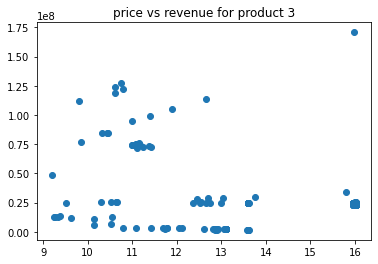

In [74]:
plt.scatter(transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 3].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 3")
plt.show()

In [27]:
transaction_df[(transaction_df["price"] > 12) & (transaction_df["product"] == 0)]

,tick,seller,buyer,product,amount,price,value
0,0,0,2,0,10.0,15.154425,151.544248
3,1,0,2,0,96.0,15.292603,1468.089909
5,2,0,2,0,927.0,15.292603,14176.243187
7,3,0,2,0,2149.0,15.292603,32863.804324
9,4,0,2,0,4491.0,15.292603,68679.081069
...,...,...,...,...,...,...,...
99688,52364,0,2,0,10000.0,14.556238,145562.381077
99690,52365,0,2,0,10000.0,14.556238,145562.381077
99692,52366,0,2,0,10000.0,14.556238,145562.381077
99694,52367,0,2,0,10000.0,14.556238,145562.381077


## Transaction Graph

In [28]:
G = nx.from_pandas_edgelist(transaction_df, source="seller", target="buyer", create_using=nx.DiGraph)

In [29]:
labels = pd.DataFrame(transaction_df.groupby("seller")["product"].first()).apply(lambda x: f'{x.name}:{x["product"]}', axis=1)

In [30]:
G = nx.relabel_nodes(G, labels)

In [31]:
nx.is_directed_acyclic_graph(G)

True

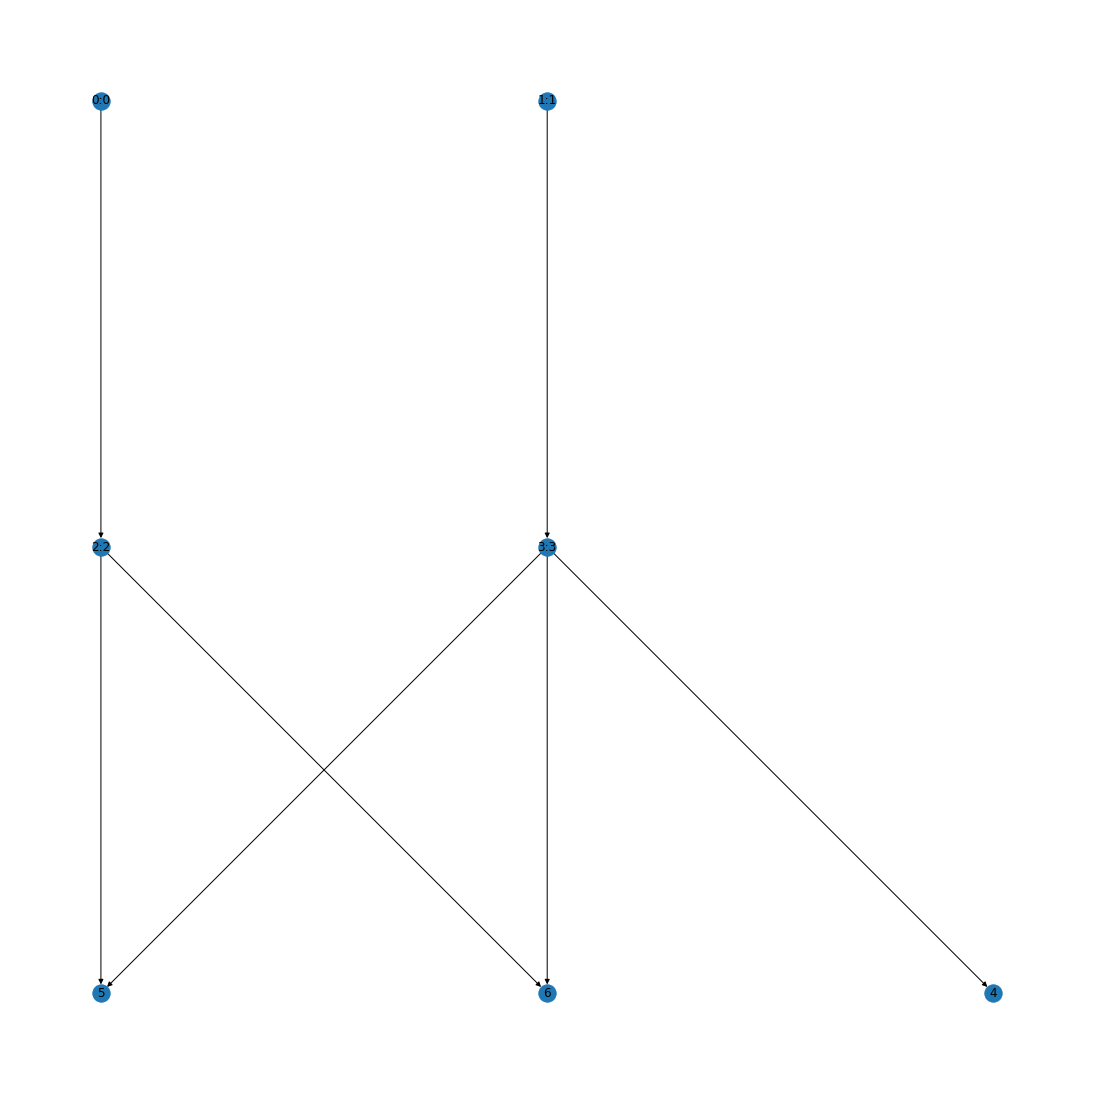

In [32]:
plt.figure(figsize=(15, 15))
#nx.draw_kamada_kawai(G, arrows=True)
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, arrows=True)
plt.show()

# Balance

In [33]:
balance_df = econ_sim.read_tick_log_to_df(open("/tmp/balance.log", "rb"), index_name="agent", column_names=["balance"])
balance_df.reset_index(inplace=True)

In [34]:
balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")

,tick,balance
agent,,
0,0,7.578353e+03
1,0,3.510630e+03
2,0,1.260592e+09
3,0,1.709880e+09
4,0,1.259027e+08
5,0,1.960790e+09
6,0,9.333250e+06


In [35]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")

,tick,balance
agent,,
0,99999,4.363660e+09
1,99999,3.599515e+09
2,99999,1.251867e+01
3,99999,7.397368e+00
4,99999,3.821594e+08
5,99999,1.972308e+09
6,99999,1.584504e+07


<AxesSubplot:xlabel='tick'>

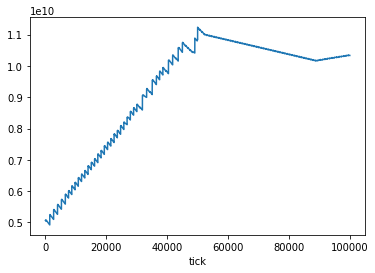

In [36]:
balance_df.groupby("tick")["balance"].sum().plot()

In [37]:
balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"].describe()

count    7.000000e+00
mean     7.237870e+08
std      8.856584e+08
min      3.510630e+03
25%      4.670414e+06
50%      1.259027e+08
75%      1.485236e+09
max      1.960790e+09
Name: balance, dtype: float64

In [38]:
balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"].describe()

count    7.000000e+00
mean     1.476213e+09
std      1.860999e+09
min      7.397368e+00
25%      7.922527e+06
50%      3.821594e+08
75%      2.785912e+09
max      4.363660e+09
Name: balance, dtype: float64

In [39]:
ltb_df = balance_df[balance_df["tick"] == balance_df["tick"].max()]

<BarContainer object of 7 artists>

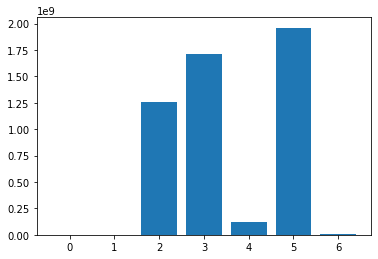

In [40]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].min()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"])

<BarContainer object of 7 artists>

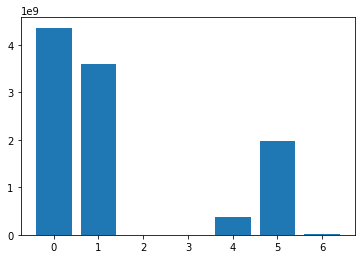

In [41]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].max()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"])

In [42]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].head(50)

,agent,tick,balance
699993,0,99999,4.363660e+09
699994,1,99999,3.599515e+09
699995,2,99999,1.251867e+01
699996,3,99999,7.397368e+00
699997,4,99999,3.821594e+08
699998,5,99999,1.972308e+09
699999,6,99999,1.584504e+07


<AxesSubplot:>

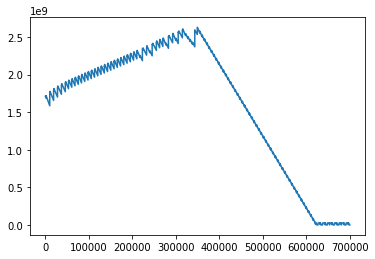

In [43]:
balance_df[balance_df["agent"] == 3]["balance"].plot()

# Inventory

In [44]:
#columns = list(map(lambda x: str(x), range(production_chain_df.shape[0])))
columns=None
inventory_df = econ_sim.read_tick_log_to_df(open("/tmp/inventory.log", "rb"), index_name="agent", column_names=columns)
inventory_df.reset_index(inplace=True)

### Last Tick Inventory

In [45]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()]

,agent,tick,0,1,2,3,4,5,6
699993,0,99999,59430.0,0.0,0.0,0.0,0.0,0.0,0.0
699994,1,99999,0.0,86181.0,0.0,0.0,0.0,0.0,0.0
699995,2,99999,1443056.0,0.0,192239444.0,0.0,0.0,0.0,0.0
699996,3,99999,0.0,658191.0,0.0,324725403.0,0.0,0.0,0.0
699997,4,99999,0.0,0.0,0.0,37905.0,0.0,0.0,0.0
699998,5,99999,0.0,0.0,11004969.0,469611.0,0.0,0.0,0.0
699999,6,99999,0.0,0.0,68993.0,1251.0,0.0,0.0,0.0


### Produced Goods Inventory

In [46]:
agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,tick
0,59430.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,86181.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,192239444.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,324725403.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


### Input Resources Inventory

In [47]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,tick
agent,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,1443056.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,658191.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,37905.0,0.0,0.0,0.0,NaN
5,0.0,0.0,11004969.0,469611.0,0.0,0.0,0.0,NaN
6,0.0,0.0,68993.0,1251.0,0.0,0.0,0.0,NaN


### Production Surplus/Deficit

In [48]:
(inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")) - (agent_goods_df @ production_chain_df.T)

,0,1,2,3,4,5,6,tick
agent,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,1443055.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,658190.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,-119179.0,0.0,0.0,0.0,NaN
5,0.0,0.0,9908839.0,-864791.0,0.0,0.0,0.0,NaN
6,0.0,0.0,62106.0,-3407.0,0.0,0.0,0.0,NaN


# Buy and Sell Prices

In [49]:
buy_price_df = econ_sim.read_tick_log_to_df(open("/tmp/buy_prices.log", "rb"), index_name="agent").reset_index()
sell_price_df = econ_sim.read_tick_log_to_df(open("/tmp/sell_prices.log", "rb"), index_name="agent").reset_index()

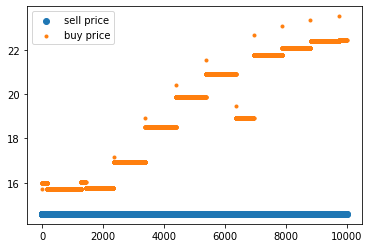

In [50]:
df1 = sell_price_df[(sell_price_df["agent"] == 0) & (sell_price_df["tick"] <10000)]
df2 = buy_price_df[buy_price_df["tick"] < 10000].groupby("tick")[0].max()
plt.scatter(df1["tick"], df1[0], label="sell price")
plt.scatter(df1["tick"], df2, label="buy price", marker=".")
plt.legend()

In [51]:
buy_price_df[buy_price_df["tick"] == buy_price_df["tick"].max()].set_index("agent")

,tick,0,1,2,3,4,5,6
agent,,,,,,,,
0,99999,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,99999,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,99999,21.793351,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,99999,0.000000,13.599746,0.000000,0.000000,0.0,0.0,0.0
4,99999,0.000000,0.000000,0.000000,16.029984,0.0,0.0,0.0
5,99999,0.000000,0.000000,25.805099,8.190982,0.0,0.0,0.0
6,99999,0.000000,0.000000,21.625295,8.100385,0.0,0.0,0.0


In [52]:
sell_price_df[sell_price_df["tick"] == sell_price_df["tick"].max()].set_index("agent")

,tick,0,1,2,3,4,5,6
agent,,,,,,,,
0,99999,7.319126,inf,inf,inf,inf,inf,inf
1,99999,inf,5.844922,inf,inf,inf,inf,inf
2,99999,inf,inf,14.556238,inf,inf,inf,inf
3,99999,inf,inf,inf,387.263362,inf,inf,inf
4,99999,inf,inf,inf,inf,2.249027e+06,inf,inf
5,99999,inf,inf,inf,inf,inf,3.853301e+07,inf
6,99999,inf,inf,inf,inf,inf,inf,1.811803e+05


In [53]:
buy_price_df[buy_price_df["tick"] == buy_price_df["tick"].max()].set_index("agent").max(axis=0) - sell_price_df[sell_price_df["tick"] == sell_price_df["tick"].max()].set_index("agent").min(axis=0)

tick    0.000000e+00
0       1.447423e+01
1       7.754823e+00
2       1.124886e+01
3      -3.712334e+02
4      -2.249027e+06
5      -3.853301e+07
6      -1.811803e+05
dtype: float64

In [54]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")

,tick,balance
agent,,
0,99999,4.363660e+09
1,99999,3.599515e+09
2,99999,1.251867e+01
3,99999,7.397368e+00
4,99999,3.821594e+08
5,99999,1.972308e+09
6,99999,1.584504e+07


# Profit Analysis

In [55]:
revenue = transaction_df.groupby("seller")["value"].sum()
costs = transaction_df.groupby("buyer")["value"].sum()

In [56]:
costs

buyer
2    7.938358e+09
3    9.025671e+09
4    3.901050e+09
5    9.988512e+09
6    1.039939e+08
Name: value, dtype: float64

In [57]:
revenue

seller
0    7.938358e+09
1    9.025671e+09
2    6.677766e+09
3    7.315791e+09
Name: value, dtype: float64

In [58]:
revenue-costs

0             NaN
1             NaN
2   -1.260592e+09
3   -1.709880e+09
4             NaN
5             NaN
6             NaN
Name: value, dtype: float64

In [59]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")

,tick,balance
agent,,
0,99999,4.363652e+09
1,99999,3.599512e+09
2,99999,-1.260592e+09
3,99999,-1.709880e+09
4,99999,2.562567e+08
5,99999,1.151781e+07
6,99999,6.511792e+06


# Production Efficiency

In [60]:
production_efficiency_df = econ_sim.read_tick_log_to_df(open("/tmp/production_efficiency.log", "rb"), index_name="agent")

In [61]:
production_efficiency_df.index.to_frame()["tick"]

agent  tick 
0      0            0
1      0            0
2      0            0
3      0            0
4      0            0
                ...  
2      99999    99999
3      99999    99999
4      99999    99999
5      99999    99999
6      99999    99999
Name: tick, Length: 700000, dtype: int64

<AxesSubplot:xlabel='tick'>

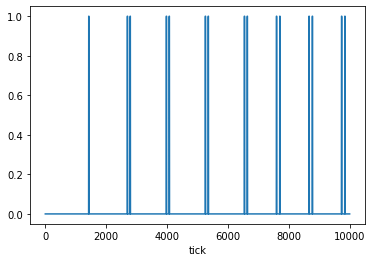

In [62]:
production_efficiency_df[production_efficiency_df.index.to_frame()["tick"] < 10000].groupby("tick").max()[4].plot()

(0.0, 17.554713123131137)

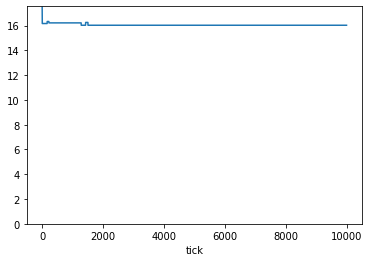

In [63]:
buy_price_df[(buy_price_df["tick"] < 10000)].groupby("tick")[3].max().plot()
plt.ylim(0)

<AxesSubplot:xlabel='tick'>

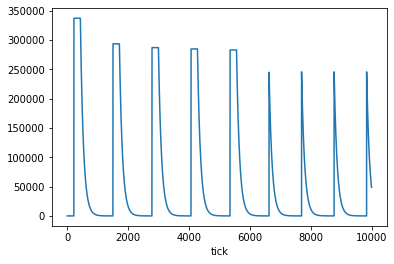

In [71]:
sell_price_df[(sell_price_df["tick"] < 10000)].groupby("tick")[3].min().plot()

In [65]:
sell_price_df.groupby("tick")[3].min().describe()

count    100000.000000
mean      17784.692567
std       49842.035919
min           7.325343
25%         100.808281
50%         961.356389
75%        9069.716352
max      337362.443731
Name: 3, dtype: float64

<AxesSubplot:xlabel='tick'>

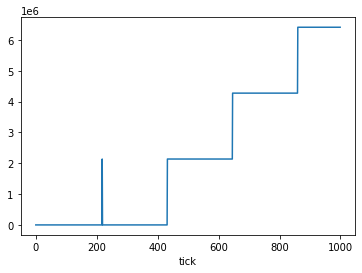

In [67]:
inventory_df[(inventory_df["tick"] < 1000) & (inventory_df["agent"] == 3)].groupby("tick")[3].max().plot()

<AxesSubplot:xlabel='tick'>

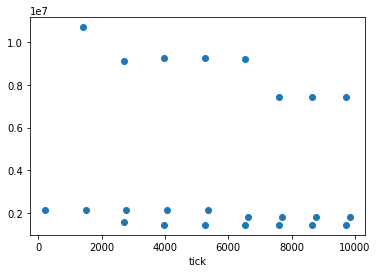

In [68]:
transaction_df[(transaction_df["tick"] < 10000) & (transaction_df["seller"] == 3)].groupby("tick")["amount"].sum().plot(marker="o", linestyle='none')

In [69]:
transaction_df[(transaction_df["tick"] < 10000) & (transaction_df["seller"] == 3)]

,tick,seller,buyer,product,amount,price,value
442,219,3,6,3,48101.0,15.815982,7.607646e+05
443,219,3,5,3,2089249.0,15.782681,3.297395e+07
2856,1424,3,6,3,45181.0,15.986753,7.222975e+05
2857,1424,3,4,3,1575105.0,15.986575,2.518053e+07
2858,1424,3,5,3,9066464.0,15.980816,1.448895e+08
3016,1502,3,6,3,54871.0,13.763895,7.552387e+05
3017,1502,3,5,3,2082479.0,13.739489,2.861220e+07
5401,2692,3,4,3,1569217.0,16.002988,2.511216e+07
5403,2693,3,4,3,189075.0,13.093748,2.475700e+06
5404,2693,3,6,3,50691.0,12.443277,6.307622e+05
